### import libraries

In [1]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.graphics.api import abline_plot
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
import re
from itertools import product, combinations
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings("ignore")

### import and format dataset

In [2]:
FILEPATH = 'C:/Users/trarg/Documents/SM/SM Experiment/DATA/Stats/Regression_Model/markov_chain_data.xlsx'#please change the folder path to the location the data was saved

df = pd.read_excel(FILEPATH)

df

,Occlusion_Chains,TwoBack_Chains,Fatigue_Chains,from_Console(13)_to_Driver Lap(20),from_Console(13)_to_Driver Mirror(18),from_Console(13)_to_Instruments(9),from_Console(13)_to_Off Road(23),from_Console(13)_to_On Road(1),from_Console(13)_to_Passenger Mirror(19),from_Console(13)_to_Rear Mirror(17),...,from_Rear Mirror(17)_to_Passenger Mirror(19),from_Rear Mirror(17)_to_Other (0),from_Other (0)_to_Console(13),from_Other (0)_to_Driver Lap(20),from_Other (0)_to_Driver Mirror(18),from_Other (0)_to_Instruments(9),from_Other (0)_to_Off Road(23),from_Other (0)_to_On Road(1),from_Other (0)_to_Passenger Mirror(19),from_Other (0)_to_Rear Mirror(17)
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
101,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
102,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
103,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0


In [3]:
## clean df names
def clean_col(name):
    # Remove "(number)"
    name = re.sub(r"\(\d+\)", "", name)
    # Replace spaces with underscores
    name = name.replace(" ", "_")
    # Remove possible double underscores from cleanup
    name = re.sub(r"_+", "_", name)
    # Strip trailing underscores
    return name.strip("_")

df.columns = [clean_col(col) for col in df.columns]


df

,Occlusion_Chains,TwoBack_Chains,Fatigue_Chains,from_Console_to_Driver_Lap,from_Console_to_Driver_Mirror,from_Console_to_Instruments,from_Console_to_Off_Road,from_Console_to_On_Road,from_Console_to_Passenger_Mirror,from_Console_to_Rear_Mirror,...,from_Rear_Mirror_to_Passenger_Mirror,from_Rear_Mirror_to_Other,from_Other_to_Console,from_Other_to_Driver_Lap,from_Other_to_Driver_Mirror,from_Other_to_Instruments,from_Other_to_Off_Road,from_Other_to_On_Road,from_Other_to_Passenger_Mirror,from_Other_to_Rear_Mirror
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
101,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
102,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
103,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0


## define model functions

In [4]:
def run_tweedie_with_emm_and_significance(df, DV):
    '''
    function that receives the dataset and the designated transition chain and run the GLMM
    fitted to a tweedie distribution.
    There is a variation commented in this code to run the GLMMs accounting for the fatigue manipulations.
    '''
    
    #predictors = ["Occlusion_Chains", "TwoBack_Chains", "Fatigue_Chains"]
    predictors = ["Occlusion_Chains", "TwoBack_Chains"]
    coef_names = ["Intercept"] + predictors

    # 1. Check for variance
    if df[DV].nunique() <= 1: 
        #if the variance in the variance in the chain is 0, the model cannot be fit. and an empty model is generated
        #this generally happens in cases where no gaze transitions of this chain occurred (i.e., 0% probability)
        print(f"\nChain for {DV} could not be modelled as variance = 0\n")
        results = pd.DataFrame({
            "coef": [0.0] * len(coef_names),
            "std_err": [0.0] * len(coef_names),
            "z": [0.0] * len(coef_names),
            "p_value": [1.0] * len(coef_names)
        }, index=coef_names)
        return None, results, None

    try:
        # Fit the model
        #formulaString = f"{DV} ~ Occlusion_Chains + TwoBack_Chains + Fatigue_Chains"
        formulaString = f"{DV} ~ Occlusion_Chains + TwoBack_Chains"
        glm_model = smf.glm(
            formula=formulaString,
            data=df,
            family=sm.families.Tweedie(link=sm.families.links.identity())
            #family=sm.families.Tweedie(link=sm.families.links.log()) #change here to test with a log-link function
        )
        res = glm_model.fit()

        # Coefficient table
        results = pd.DataFrame({
            "coef": res.params,
            "std_err": res.bse,
            "z": res.tvalues,
            "p_value": res.pvalues
        })

        # Compute estimated marginal means (EMMs) for each predictor
        emms_list = []
        for pred in ["TwoBack_Chains", "Occlusion_Chains"]:
        #for pred in ["TwoBack_Chains", "Occlusion_Chains", "Fatigue_Chains""]:
            if pred not in df.columns:
                continue
            for val in sorted(df[pred].dropna().unique()):
                row = {col: df[col].mean() if col in predictors else 0 for col in predictors}
                row[pred] = val
                pred_df = pd.DataFrame([row])
                pred_mean = res.predict(pred_df)[0]
                emms_list.append({"Predictor": pred, "Level": val, "Predicted_Mean": pred_mean})

        emms = pd.DataFrame(emms_list)

            
        return res,results, emms

    except Exception as e:
        print(f"\nChain for {DV} could not be modelled when calculating log likelihood of 0\n")
        results = pd.DataFrame({
            "coef": [0.0] * len(coef_names),
            "std_err": [0.0] * len(coef_names),
            "z": [0.0] * len(coef_names),
            "p_value": [1.0] * len(coef_names)
        }, index=coef_names)
        return None, results, None

In [5]:
def posthoc_and_plot_tweedie_wilcoxon(model_res, df, DV, predictors, n_sim=1000):
    """
    Computes:
      - EMMs for Tweedie GLMM
      - Tweedie variances
      - Wilcoxon tests
      - Boxplot of simulated (truncated 0–1 → 0–100%) distributions
    """

    # -----------------------------------------------------------
    # 1. Generate combinations of predictors
    # -----------------------------------------------------------
    levels = [sorted(df[p].dropna().unique()) for p in predictors]
    combos = list(product(*levels))

    # -----------------------------------------------------------
    # 2. Extract Tweedie dispersion and power
    # -----------------------------------------------------------
    phi = model_res.scale
    try:
        tweedie_power = float(model_res.model.family.var_power)
    except:
        tweedie_power = float(model_res.model.family.power)

    # -----------------------------------------------------------
    # 3. Compute EMMs + variance
    # -----------------------------------------------------------
    emms_list = []
    for combo in combos:

        row = {p: df[p].mean() for p in predictors}
        for i, p in enumerate(predictors):
            row[p] = combo[i]

        pred_df = pd.DataFrame([row])
        pred_mean = float(model_res.predict(pred_df)[0])
        pred_var = phi * (pred_mean ** tweedie_power)

        emms_list.append({
            "Condition": combo,
            "Predicted_Mean": pred_mean,
            "Predicted_Var": pred_var
        })

    emms_df = pd.DataFrame(emms_list)

    # Remove the (0,0) baseline
    emms_df = emms_df[emms_df["Condition"] != (0.0, 0.0)]

    # -----------------------------------------------------------
    # 4. Simulate Tweedie-based distributions (truncate 0–1)
    # -----------------------------------------------------------
    sim_data = {}
    for _, row in emms_df.iterrows():
        cond = row["Condition"]
        mean = row["Predicted_Mean"]
        var = row["Predicted_Var"]

        sd = np.sqrt(var) if var >= 0 else 0
        sim = np.random.normal(loc=mean, scale=sd, size=n_sim)
        sim = np.clip(sim, 0, 1)  # truncate

        sim_data[cond] = sim

    # -----------------------------------------------------------
    # 5. Wilcoxon tests
    # -----------------------------------------------------------

    pairwise_list = []
    for c1, c2 in combinations(sim_data.keys(), 2):
        try:
            stat, p = wilcoxon(sim_data[c1], sim_data[c2])
            pairwise_list.append({
                "Condition1": c1,
                "Condition2": c2,
                "Mean_Diff": sim_data[c1].mean() - sim_data[c2].mean(),
                "Wilcoxon_stat": stat,
                "p_value": p
            })
        except:
            print (f'\n Could not run pairwise comparrissons for {DV} as one of the conditions only contains zeros')
    pairwise_df = pd.DataFrame(pairwise_list)

    # -----------------------------------------------------------
    # Print tables
    # -----------------------------------------------------------
    print("\n=== Estimated Marginal Means (with Tweedie Variance) ===")
    print(emms_df)

    print("\n=== Wilcoxon Signed-Rank Comparisons ===")
    print(pairwise_df)

    # -----------------------------------------------------------
    # 6. Plot boxplots
    # -----------------------------------------------------------

    label_map = {
        (0.0, 1.0): "Occlusion",
        (1.0, 0.0): "2-Back",
        (1.0, 1.0): "Occlusion+2-Back"
    }

    plt.figure(figsize=(6, 5))

    box_data = [sim_data[c] * 100 for c in sim_data.keys()]  # → percentage
    labels = [label_map[c] for c in sim_data.keys()]

    plt.boxplot(
        box_data,
        labels=labels,
        patch_artist=True,
        boxprops=dict(facecolor="lightgray"),
        medianprops=dict(color="black", linewidth=1.5),
        showfliers=False,
        widths=0.4
    )

    # Title cleanup: replace "_" with space, Title Case
    clean_title = DV.replace("_", " ").title()
    plt.title(clean_title, fontsize=16)

    # Y axis name
    plt.ylabel("Predicted gaze transition probability", fontsize=16)

    # Add slight padding above and below
    plt.ylim(-2, 102)

    # Convert ticks to percentage labels
    yticks = np.linspace(0, 100, 6)
    plt.yticks(yticks, [f"{int(y)}%" for y in yticks], fontsize = 15)

    # Compact x-axis labels
    plt.xticks(fontsize=15, rotation=15)

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    return emms_df, pairwise_df

### run the models for the SIGNIFICANT transitions


Chain for from_Console_to_On_Road could not be modelled when calculating log likelihood of 0


Chain for from_Driver_Mirror_to_Instruments could not be modelled when calculating log likelihood of 0


DV: from_Driver_Mirror_to_Off_Road
                      coef   std_err         z   p_value
Intercept         0.022306  0.069496  0.320969  0.748234
Occlusion_Chains  0.098906  0.050409  1.962084  0.049753
TwoBack_Chains    0.000216  0.066711  0.003245  0.997411

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.121212       0.075526
2    (1, 0)        0.022523       0.014034
3    (1, 1)        0.121429       0.075661

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat   p_value
0     (0, 1)     (1, 0)   0.107907         1031.0  0.000006
1     (0, 1)     (1, 1)  -0.007900         2160.0  0.784551
2     (1, 0)     (1, 1)  -0.115808         1027.0  0.000005


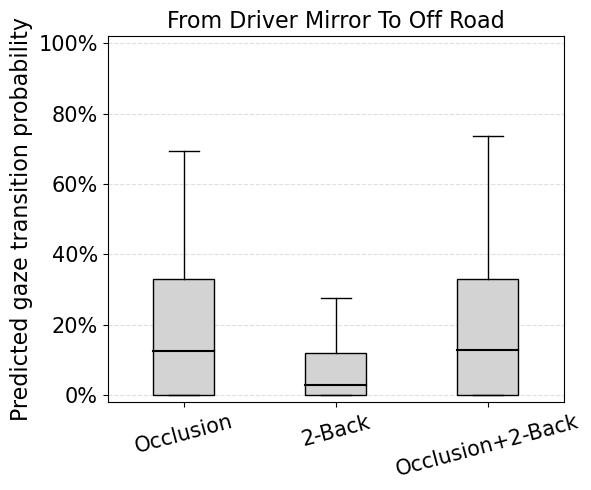


DV: from_Instruments_to_On_Road
                      coef   std_err         z   p_value
Intercept         0.347941  0.125740  2.767148  0.005655
Occlusion_Chains  0.068726  0.077309  0.888981  0.374013
TwoBack_Chains   -0.245238  0.116827 -2.099149  0.035804

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.416667       0.324518
2    (1, 0)        0.102703       0.079989
3    (1, 1)        0.171429       0.133516

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)   0.280051          990.0  7.822523e-08
1     (0, 1)     (1, 1)   0.256902          990.0  2.180894e-07
2     (1, 0)     (1, 1)  -0.023149         1993.0  4.607687e-01


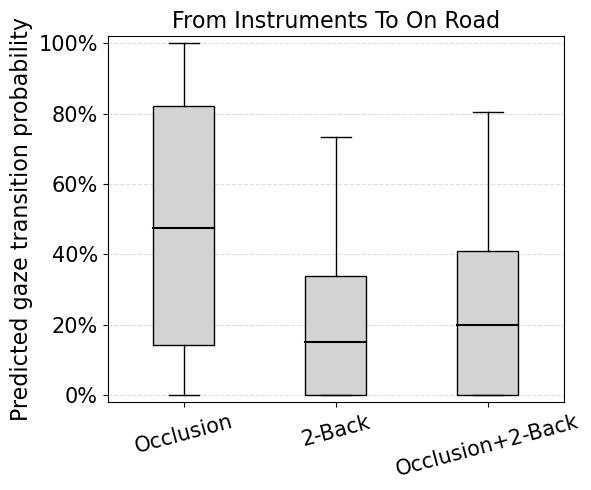


Chain for from_Off_Road_to_Rear_Mirror could not be modelled when calculating log likelihood of 0


DV: from_On_Road_to_Instruments
                      coef   std_err         z   p_value
Intercept         0.186699  0.064252  2.905721  0.003664
Occlusion_Chains  0.005557  0.035148  0.158104  0.874375
TwoBack_Chains   -0.144807  0.059717 -2.424884  0.015313

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.192256       0.095467
2    (1, 0)        0.041892       0.020802
3    (1, 1)        0.047449       0.023561

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)   0.151830          899.0  2.292792e-06
1     (0, 1)     (1, 1)   0.165888          779.0  1.985518e-07
2     (1, 0)     (1, 1)   0.014058         1482.0  2.360273e-01


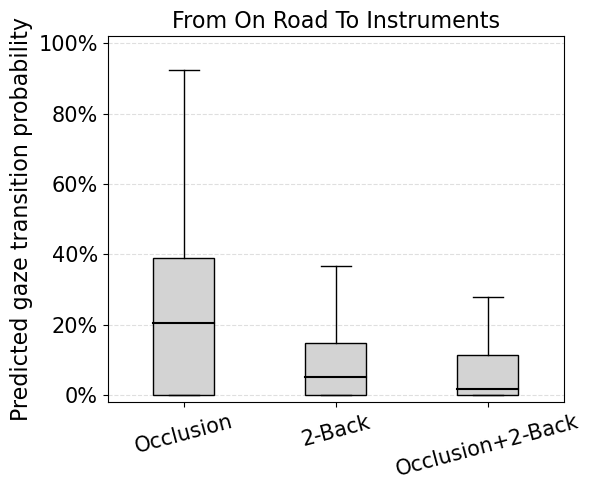


DV: from_On_Road_to_Off_Road
                      coef   std_err         z   p_value
Intercept         0.384982  0.125563  3.066035  0.002169
Occlusion_Chains  0.264177  0.095932  2.753789  0.005891
TwoBack_Chains   -0.024621  0.111878 -0.220073  0.825814

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.649158       0.216586
2    (1, 0)        0.360360       0.120231
3    (1, 1)        0.624537       0.208371

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat   p_value
0     (0, 1)     (1, 0)   0.224350         1350.0  0.000012
1     (0, 1)     (1, 1)   0.033724         2190.0  0.319846
2     (1, 0)     (1, 1)  -0.190626         1515.0  0.000130


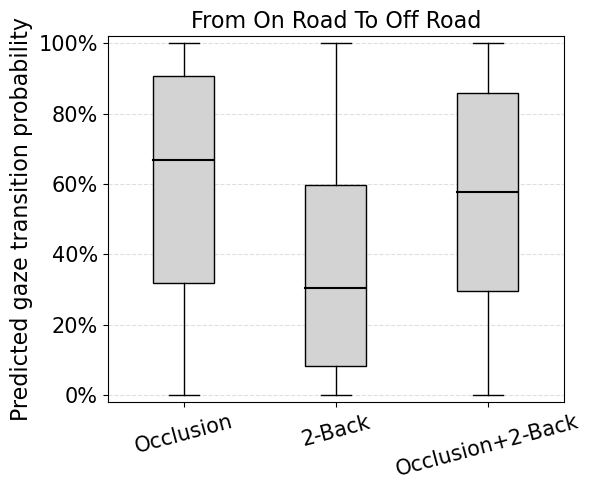


Chain for from_On_Road_to_Passenger_Mirror could not be modelled when calculating log likelihood of 0


Chain for from_Passenger_Mirror_to_Off_Road could not be modelled when calculating log likelihood of 0


Chain for from_Passenger_Mirror_to_Rear_Mirror could not be modelled when calculating log likelihood of 0


Chain for from_Rear_Mirror_to_Off_Road could not be modelled when calculating log likelihood of 0



In [6]:
#defines the col in the dataset where the first gaze transition chain appears in df
firstChain = 3 
# Loop over columns and print significant results
for i in range(firstChain, len (df.columns)):
    DV = df.columns[i]
    if (np.var (df[DV]) <= 0.0): #checks for minimal variance to run the model
        continue

    model, results, emms = run_tweedie_with_emm_and_significance(df, DV)
    if results is not None:
        # Only print if any predictor is significant
        if (results.loc[['Occlusion_Chains', 'TwoBack_Chains'], 'p_value'] <= 0.05).any():
            print(f"\nDV: {DV}")
            print(results)
            
            predictors = ["TwoBack_Chains", "Occlusion_Chains"]
            
            #estimate EMMs, and plot the wilcoxon test results
            emms_df, pairwise_df = posthoc_and_plot_tweedie_wilcoxon(model, df, DV, predictors, n_sim=105)


### run models for NON-SIGNIFICANT transitions


Chain for from_Console_to_Driver_Lap could not be modelled as variance = 0


DV: from_Console_to_Driver_Lap
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Console_to_Driver_Mirror could not be modelled as variance = 0


DV: from_Console_to_Driver_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Console_to_Instruments could not be modelled as variance = 0


DV: from_Console_to_Instruments
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Console_to_Off_Road
                          coef       std_err             z   p_value
Intercept     

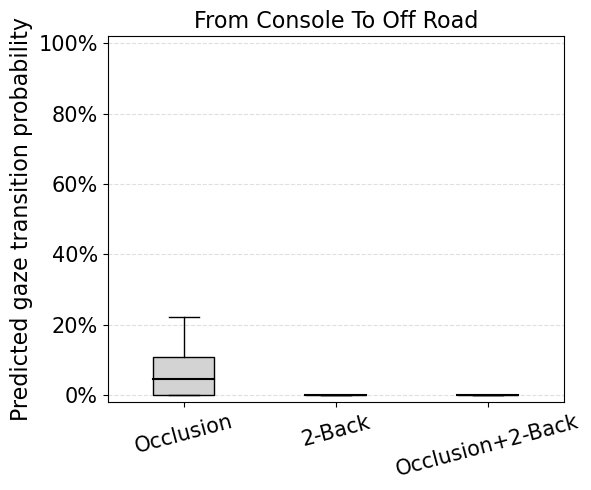


Chain for from_Console_to_On_Road could not be modelled when calculating log likelihood of 0


DV: from_Console_to_On_Road
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Console_to_Passenger_Mirror could not be modelled as variance = 0


DV: from_Console_to_Passenger_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Console_to_Rear_Mirror could not be modelled as variance = 0


DV: from_Console_to_Rear_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Console_to_Other could not be modelled as variance = 0


DV: from_Console_to

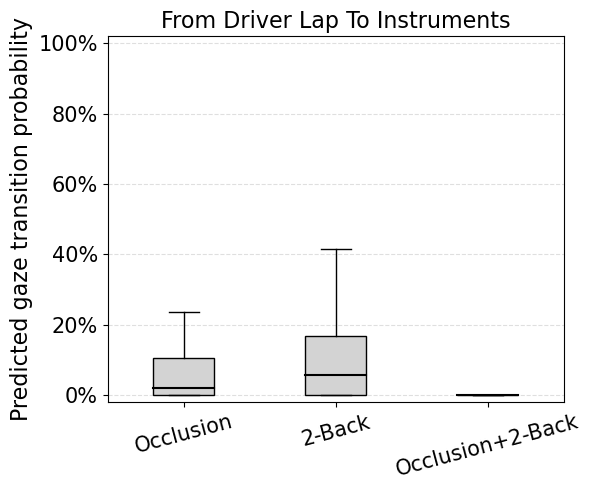


Chain for from_Driver_Lap_to_Off_Road could not be modelled as variance = 0


DV: from_Driver_Lap_to_Off_Road
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Driver_Lap_to_On_Road
                      coef   std_err         z   p_value
Intercept        -0.028571  0.016496 -1.732051  0.083265
Occlusion_Chains  0.028571  0.016496  1.732051  0.083265
TwoBack_Chains    0.028571  0.016496  1.732051  0.083265

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    3.469447e-17   1.156482e-17
2    (1, 0)   -6.938894e-18  -2.312965e-18
3    (1, 1)    2.857143e-02   9.523810e-03

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2     Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)  1.321472e-09            0.0  5.168395e-12
1     (0, 1)     (1, 1) -5.132239e-02  

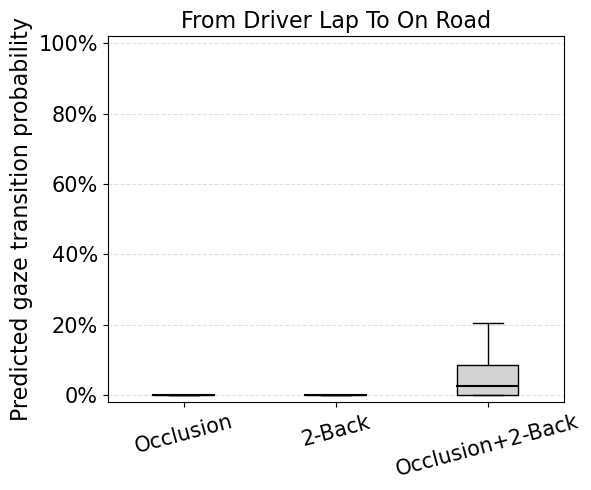


Chain for from_Driver_Lap_to_Passenger_Mirror could not be modelled as variance = 0


DV: from_Driver_Lap_to_Passenger_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Driver_Lap_to_Rear_Mirror could not be modelled as variance = 0


DV: from_Driver_Lap_to_Rear_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Driver_Lap_to_Other could not be modelled as variance = 0


DV: from_Driver_Lap_to_Other
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Driver_Mirror_to_Console could not be modelled as variance = 0


DV: from_Driver_Mi

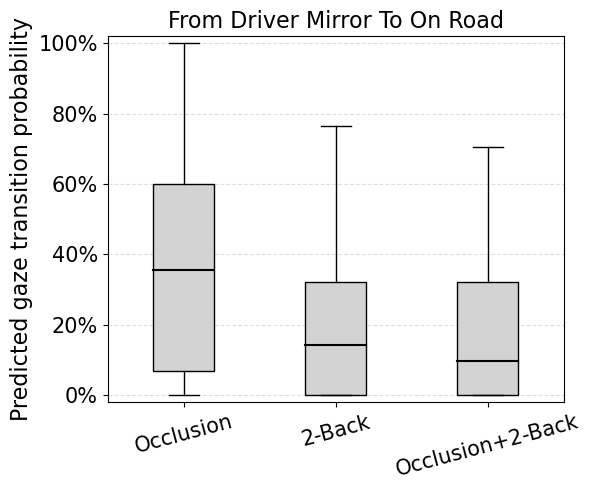


DV: from_Driver_Mirror_to_Passenger_Mirror
                      coef   std_err         z   p_value
Intercept         0.006371  0.012162  0.523825  0.600400
Occlusion_Chains -0.006371  0.012162 -0.523825  0.600400
TwoBack_Chains    0.007143  0.007282  0.980951  0.326617

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)   -2.602085e-18  -6.760319e-19
2    (1, 0)    1.351351e-02   3.510864e-03
3    (1, 1)    7.142857e-03   1.855742e-03

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)  -0.037736            0.0  7.641055e-13
1     (0, 1)     (1, 1)  -0.021023            0.0  7.577765e-12
2     (1, 0)     (1, 1)   0.016713         1210.0  2.886229e-03


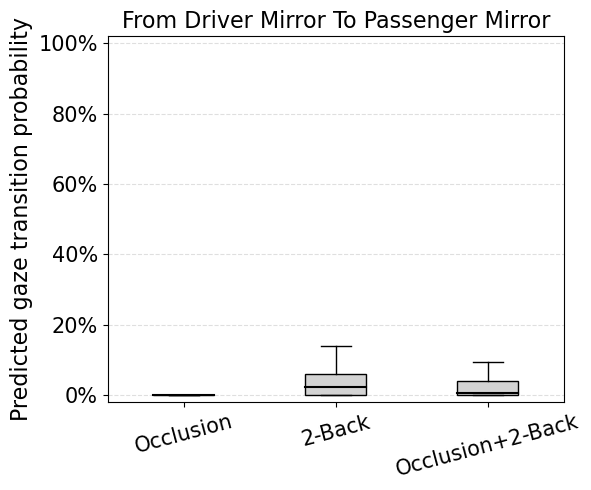


Chain for from_Driver_Mirror_to_Rear_Mirror could not be modelled as variance = 0


DV: from_Driver_Mirror_to_Rear_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Driver_Mirror_to_Other could not be modelled as variance = 0


DV: from_Driver_Mirror_to_Other
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Instruments_to_Console could not be modelled as variance = 0


DV: from_Instruments_to_Console
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Instruments_to_Driver_Lap could not be modelled as variance = 0


DV: from_Instruments_

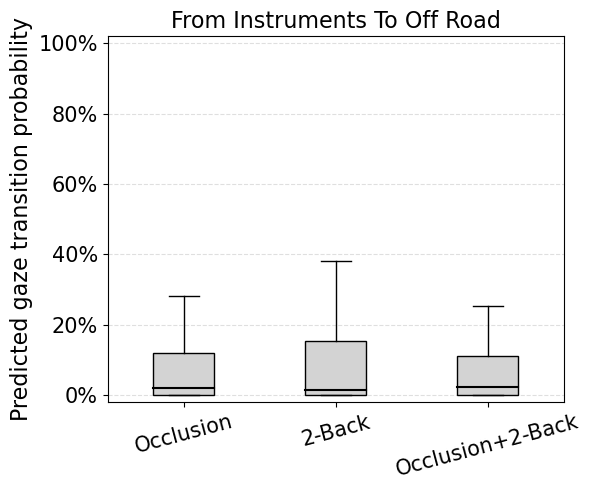


Chain for from_Instruments_to_Passenger_Mirror could not be modelled as variance = 0


DV: from_Instruments_to_Passenger_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Instruments_to_Rear_Mirror
                      coef   std_err         z   p_value
Intercept         0.012981  0.007482  1.734979  0.082745
Occlusion_Chains -0.005405  0.004666 -1.158493  0.246663
TwoBack_Chains   -0.007576  0.005849 -1.295234  0.195239

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    7.575758e-03   1.128936e-03
2    (1, 0)    5.405405e-03   8.055114e-04
3    (1, 1)   -9.540979e-18  -1.421793e-18

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)   0.004166         1297.0  1.666524e-01
1     (0, 1)     (1, 1

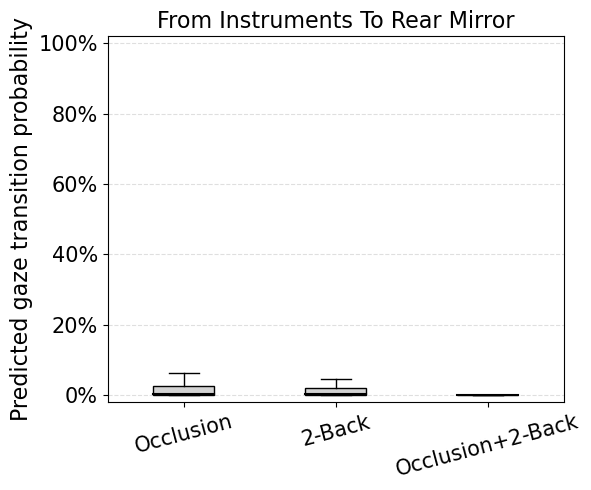


Chain for from_Instruments_to_Other could not be modelled as variance = 0


DV: from_Instruments_to_Other
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Off_Road_to_Console could not be modelled as variance = 0


DV: from_Off_Road_to_Console
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Off_Road_to_Driver_Lap could not be modelled as variance = 0


DV: from_Off_Road_to_Driver_Lap
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Off_Road_to_Driver_Mirror
                      coef   std_err         z   p_value
Intercept        -0.002824  0.02

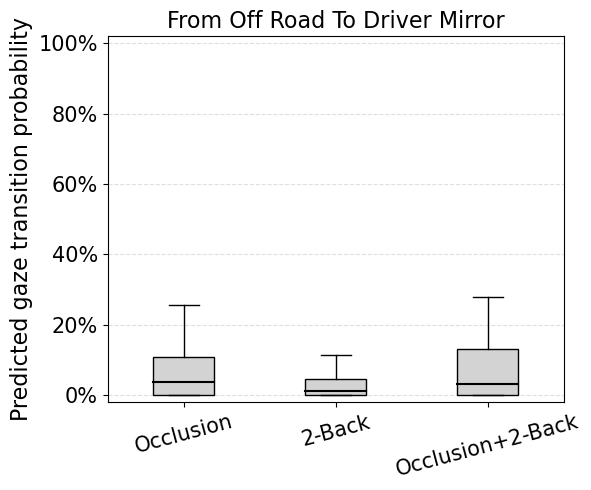


DV: from_Off_Road_to_Instruments
                      coef   std_err         z   p_value
Intercept         0.043204  0.024565  1.758783  0.078614
Occlusion_Chains -0.024986  0.018841 -1.326169  0.184784
TwoBack_Chains   -0.016177  0.016574 -0.976064  0.329033

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.018218       0.008199
2    (1, 0)        0.027027       0.012163
3    (1, 1)        0.002041       0.000918

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)  -0.015478         1874.0  1.764137e-01
1     (0, 1)     (1, 1)   0.031559          837.0  1.856701e-06
2     (1, 0)     (1, 1)   0.047037          619.0  9.039102e-09


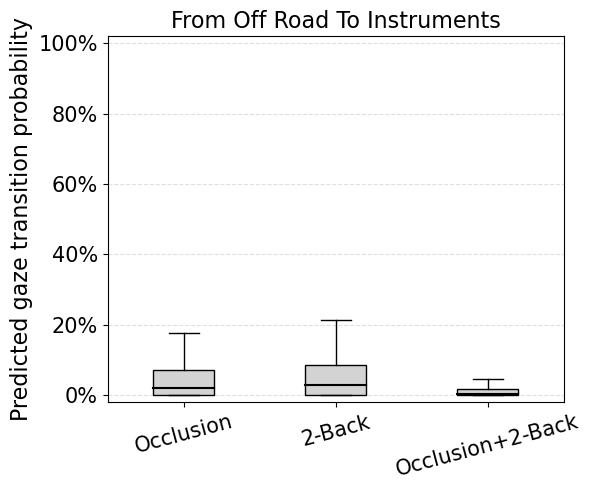


DV: from_Off_Road_to_On_Road
                      coef   std_err         z       p_value
Intercept         0.657584  0.129048  5.095661  3.475267e-07
Occlusion_Chains  0.010057  0.105101  0.095689  9.237678e-01
TwoBack_Chains    0.054128  0.106406  0.508691  6.109687e-01

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.667641       0.185033
2    (1, 0)        0.711712       0.197247
3    (1, 1)        0.721769       0.200034

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat   p_value
0     (0, 1)     (1, 0)   0.006368         2452.0  0.936017
1     (0, 1)     (1, 1)   0.011937         2472.5  0.993038
2     (1, 0)     (1, 1)   0.005569         2438.0  0.897246


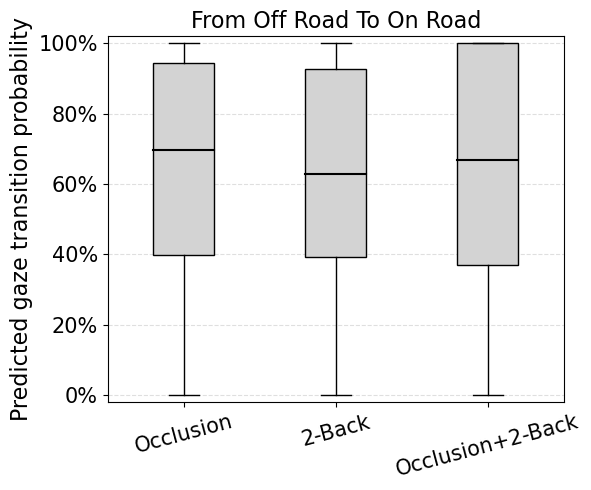


DV: from_Off_Road_to_Passenger_Mirror
                      coef   std_err         z   p_value
Intercept         0.005628  0.013998  0.402025  0.687665
Occlusion_Chains  0.009524  0.008539  1.115304  0.264720
TwoBack_Chains   -0.005628  0.013998 -0.402025  0.687665

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    1.515152e-02   4.060210e-03
2    (1, 0)   -5.204170e-18  -1.394582e-18
3    (1, 1)    9.523810e-03   2.552132e-03

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)   0.037714            0.0  3.525498e-12
1     (0, 1)     (1, 1)   0.012883         1438.0  4.394475e-02
2     (1, 0)     (1, 1)  -0.024831            0.0  3.506051e-11


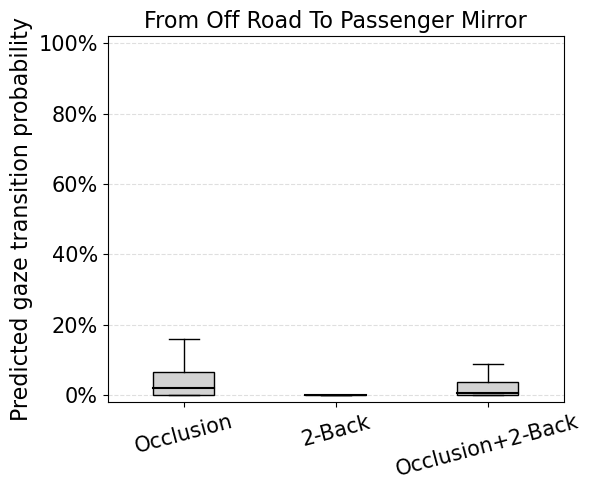


Chain for from_Off_Road_to_Rear_Mirror could not be modelled when calculating log likelihood of 0


DV: from_Off_Road_to_Rear_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Off_Road_to_Other
                          coef       std_err             z   p_value
Intercept         2.702703e-02  1.605645e-02  1.683251e+00  0.092327
Occlusion_Chains -2.702703e-02  1.605645e-02 -1.683251e+00  0.092327
TwoBack_Chains   -8.800780e-18  1.607048e-09 -5.476363e-09  1.000000

 Could not run pairwise comparrissons for from_Off_Road_to_Other as one of the conditions only contains zeros

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)   -1.040834e-17  -3.673532e-18
2    (1, 0)    2.702703e-02   9.538951e-03
3    (1, 1)   -1.920912e-17  -6.779690e-18

=== Wilcoxon Signed-Rank Comparisons

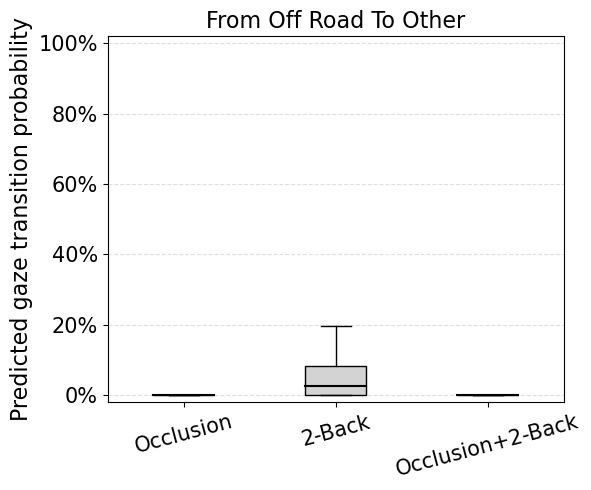


DV: from_On_Road_to_Console
                          coef       std_err             z   p_value
Intercept         6.060606e-03  3.394618e-03  1.785357e+00  0.074203
Occlusion_Chains -1.081636e-18  3.558990e-10 -3.039165e-09  1.000000
TwoBack_Chains   -6.060606e-03  3.394618e-03 -1.785357e+00  0.074203

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    6.060606e-03   3.802733e-04
2    (1, 0)    1.734723e-18   1.088454e-19
3    (1, 1)    8.673617e-19   5.442270e-20

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2     Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)  1.286342e-02          105.0  2.910537e-14
1     (0, 1)     (1, 1)  1.286342e-02          120.0  3.128074e-14
2     (1, 0)     (1, 1)  1.096317e-11         1454.0  8.094159e-01


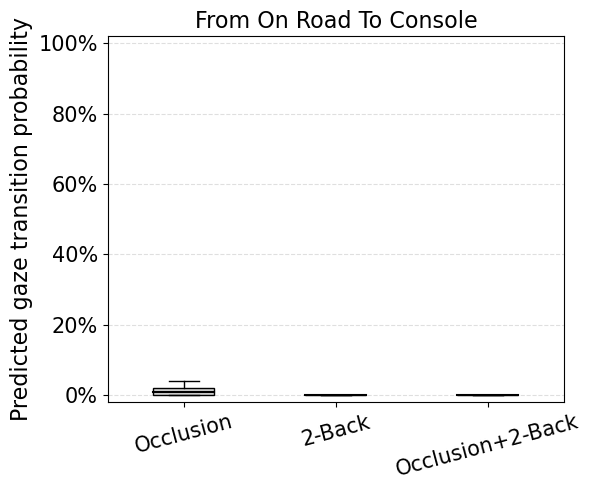


DV: from_On_Road_to_Driver_Lap
                      coef   std_err         z   p_value
Intercept         0.001553  0.012251  0.126736  0.899149
Occlusion_Chains  0.006023  0.010050  0.599293  0.548977
TwoBack_Chains    0.003853  0.010902  0.353406  0.723784

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.007576       0.001619
2    (1, 0)        0.005405       0.001155
3    (1, 1)        0.011429       0.002443

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat   p_value
0     (0, 1)     (1, 0)   0.001242         2064.0  0.770254
1     (0, 1)     (1, 1)  -0.003139         1724.0  0.650180
2     (1, 0)     (1, 1)  -0.004381         1534.0  0.262968


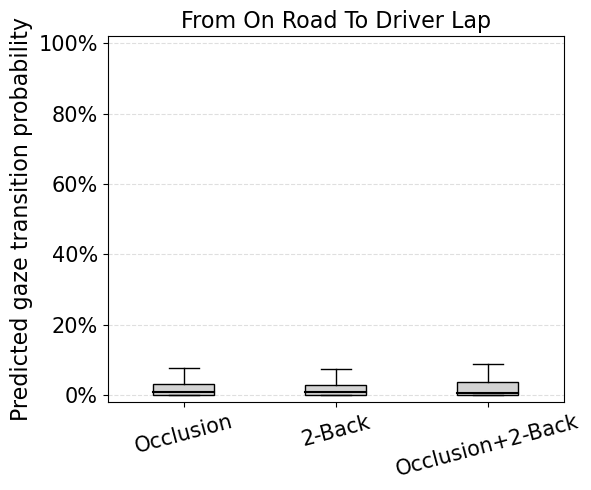


DV: from_On_Road_to_Driver_Mirror
                      coef   std_err         z   p_value
Intercept         0.152360  0.076585  1.989430  0.046654
Occlusion_Chains  0.009761  0.055140  0.177018  0.859495
TwoBack_Chains   -0.062270  0.066822 -0.931880  0.351399

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.162121       0.093219
2    (1, 0)        0.090090       0.051801
3    (1, 1)        0.099851       0.057414

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat   p_value
0     (0, 1)     (1, 0)   0.126027         1319.0  0.000021
1     (0, 1)     (1, 1)   0.077188         1802.0  0.018826
2     (1, 0)     (1, 1)  -0.048838         1663.0  0.022009


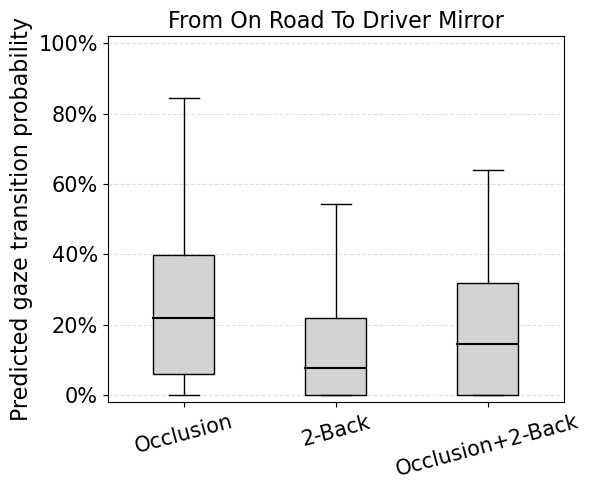


Chain for from_On_Road_to_Passenger_Mirror could not be modelled when calculating log likelihood of 0


DV: from_On_Road_to_Passenger_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_On_Road_to_Rear_Mirror
                      coef   std_err         z   p_value
Intercept         0.060955  0.058655  1.039218  0.298703
Occlusion_Chains  0.014802  0.046545  0.318020  0.750470
TwoBack_Chains    0.001657  0.050013  0.033139  0.973564

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.075758       0.042040
2    (1, 0)        0.062613       0.034745
3    (1, 1)        0.077415       0.042959

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat   p_value
0     (0, 1)     (1, 0)   0.060732         1379.0  0.007149
1     (0, 1)     (1, 

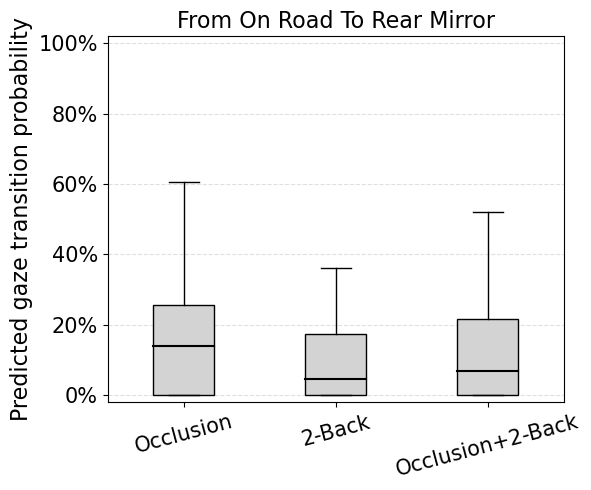


DV: from_On_Road_to_Other
                      coef   std_err         z   p_value
Intercept         0.022945  0.018420  1.245661  0.212889
Occlusion_Chains -0.022945  0.018420 -1.245661  0.212889
TwoBack_Chains    0.004082  0.006835  0.597196  0.550376

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.000000       0.000000
2    (1, 0)        0.027027       0.010826
3    (1, 1)        0.004082       0.001635

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)  -0.062681            0.0  7.577765e-12
1     (0, 1)     (1, 1)  -0.014441            0.0  3.506051e-11
2     (1, 0)     (1, 1)   0.048239          453.0  2.177570e-08


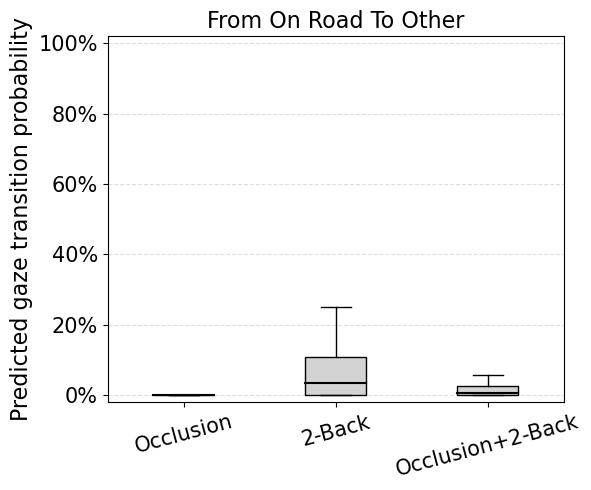


Chain for from_Passenger_Mirror_to_Console could not be modelled as variance = 0


DV: from_Passenger_Mirror_to_Console
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Passenger_Mirror_to_Driver_Lap could not be modelled as variance = 0


DV: from_Passenger_Mirror_to_Driver_Lap
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Passenger_Mirror_to_Driver_Mirror
                      coef   std_err         z   p_value
Intercept         0.043817  0.025083  1.746846  0.080664
Occlusion_Chains -0.013514  0.013380 -1.009950  0.312519
TwoBack_Chains   -0.030303  0.021216 -1.428286  0.153210

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)

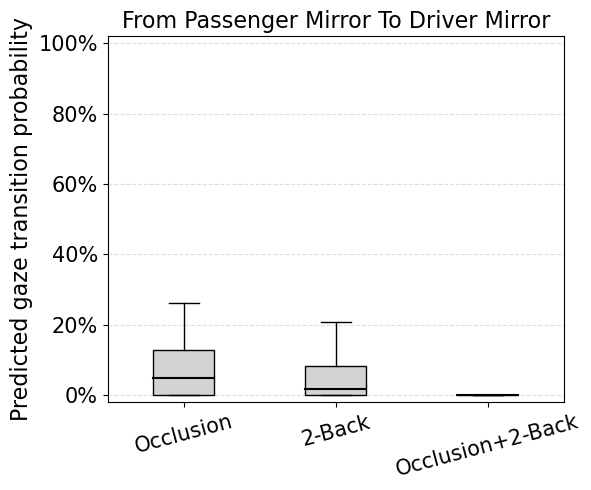


Chain for from_Passenger_Mirror_to_Instruments could not be modelled as variance = 0


DV: from_Passenger_Mirror_to_Instruments
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Passenger_Mirror_to_Off_Road could not be modelled when calculating log likelihood of 0


DV: from_Passenger_Mirror_to_Off_Road
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Passenger_Mirror_to_On_Road
                      coef   std_err         z   p_value
Intercept         0.058289  0.059885  0.973359  0.330375
Occlusion_Chains  0.002317  0.044741  0.051778  0.958705
TwoBack_Chains   -0.017749  0.051390 -0.345379  0.729809

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predic

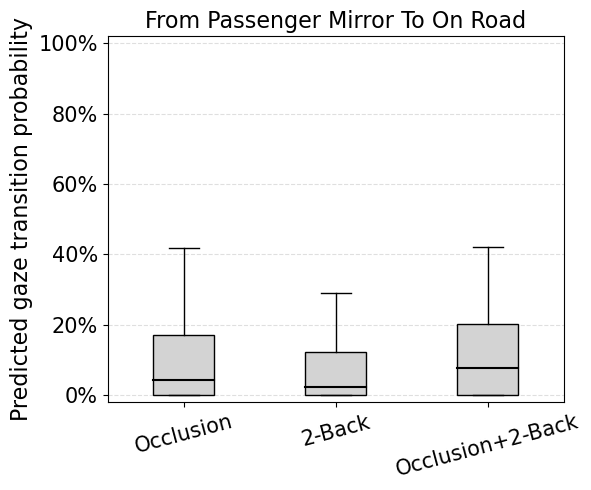


Chain for from_Passenger_Mirror_to_Rear_Mirror could not be modelled when calculating log likelihood of 0


DV: from_Passenger_Mirror_to_Rear_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Passenger_Mirror_to_Other could not be modelled as variance = 0


DV: from_Passenger_Mirror_to_Other
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Rear_Mirror_to_Console could not be modelled as variance = 0


DV: from_Rear_Mirror_to_Console
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Rear_Mirror_to_Driver_Lap
                          coef    

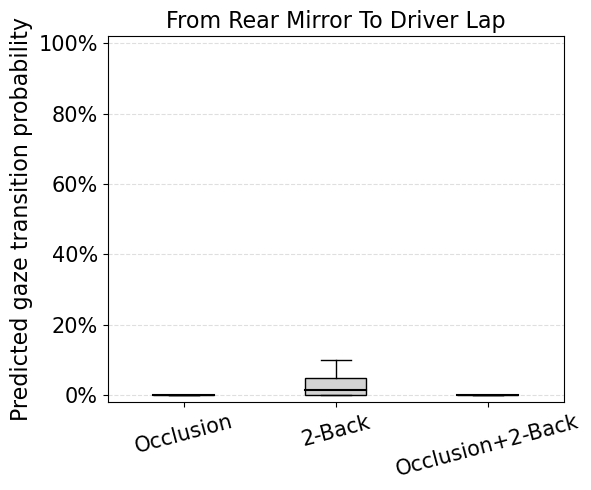


DV: from_Rear_Mirror_to_Driver_Mirror
                      coef   std_err         z   p_value
Intercept         0.001732  0.033502  0.051686  0.958779
Occlusion_Chains  0.028571  0.022983  1.243163  0.213808
TwoBack_Chains   -0.001732  0.033502 -0.051686  0.958779

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    3.030303e-02   1.960784e-02
2    (1, 0)   -3.469447e-18  -2.244936e-18
3    (1, 1)    2.857143e-02   1.848740e-02

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)   0.093857            0.0  1.658752e-13
1     (0, 1)     (1, 1)   0.027073         1733.0  5.962157e-02
2     (1, 0)     (1, 1)  -0.066783            0.0  5.143754e-11


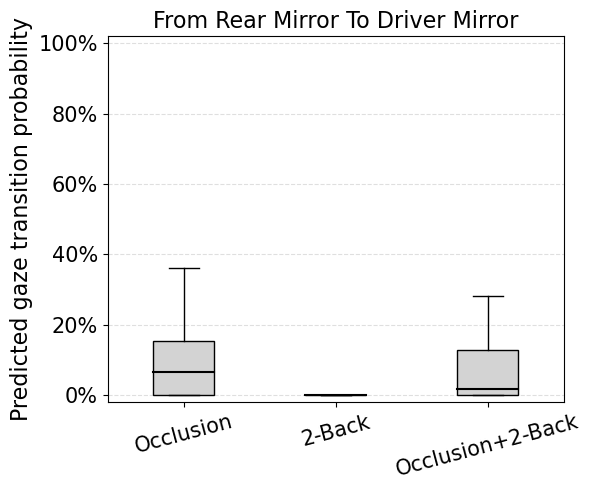


DV: from_Rear_Mirror_to_Instruments
                          coef       std_err             z   p_value
Intercept         9.009009e-03  5.352149e-03  1.683251e+00  0.092327
Occlusion_Chains -9.009009e-03  5.352149e-03 -1.683251e+00  0.092327
TwoBack_Chains   -1.536842e-18  5.292950e-10 -2.903564e-09  1.000000

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    3.469447e-18   4.081702e-19
2    (1, 0)    9.009009e-03   1.059883e-03
3    (1, 1)    1.932605e-18   2.273653e-19

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2     Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0) -1.588358e-02          351.0  6.031202e-11
1     (0, 1)     (1, 1)  7.738347e-11         1421.0  7.488197e-02
2     (1, 0)     (1, 1)  1.588358e-02          231.0  1.690952e-11


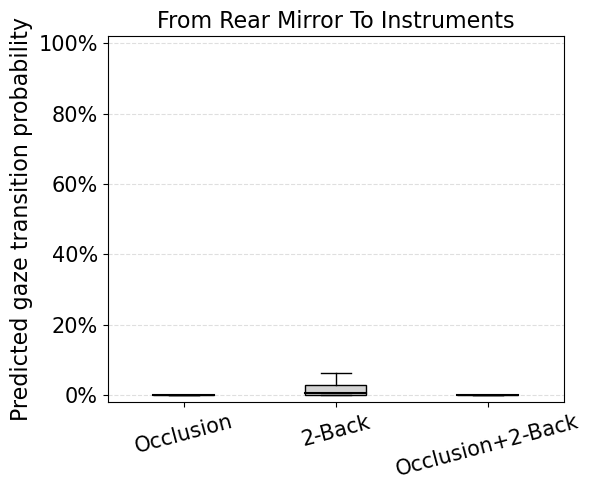


Chain for from_Rear_Mirror_to_Off_Road could not be modelled when calculating log likelihood of 0


DV: from_Rear_Mirror_to_Off_Road
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

DV: from_Rear_Mirror_to_On_Road
                      coef   std_err         z   p_value
Intercept         0.013221  0.113837  0.116140  0.907542
Occlusion_Chains  0.168597  0.093373  1.805625  0.070977
TwoBack_Chains    0.103896  0.102581  1.012824  0.311144

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)        0.181818       0.139929
2    (1, 0)        0.117117       0.090134
3    (1, 1)        0.285714       0.219888

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat   p_value
0     (0, 1)     (1, 0)   0.062997         1772.0  0.113111
1     (0, 1)     (1, 1)  -0.1

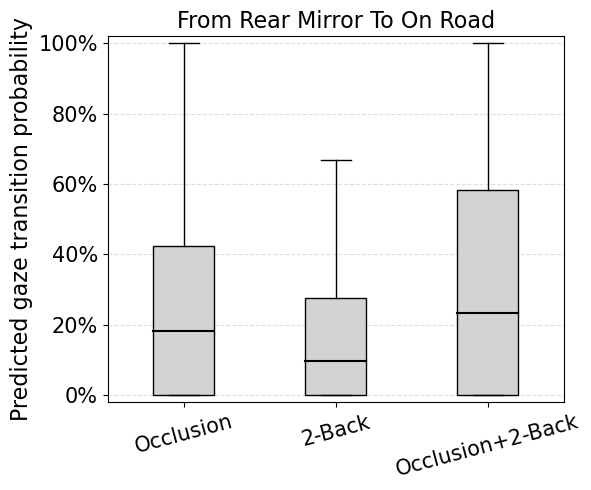


DV: from_Rear_Mirror_to_Passenger_Mirror
                          coef       std_err             z   p_value
Intercept         3.030303e-02  1.697309e-02  1.785357e+00  0.074203
Occlusion_Chains  1.354282e-16  6.970021e-10  1.943009e-07  1.000000
TwoBack_Chains   -3.030303e-02  1.697309e-02 -1.785357e+00  0.074203

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    3.030303e-02   9.506833e-03
2    (1, 0)   -6.938894e-17  -2.176908e-17
3    (1, 1)    6.591949e-17   2.068062e-17

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2     Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)  6.035280e-02            0.0  5.214927e-13
1     (0, 1)     (1, 1)  6.035280e-02          253.0  3.275760e-13
2     (1, 0)     (1, 1) -2.036015e-09            0.0  1.629556e-11


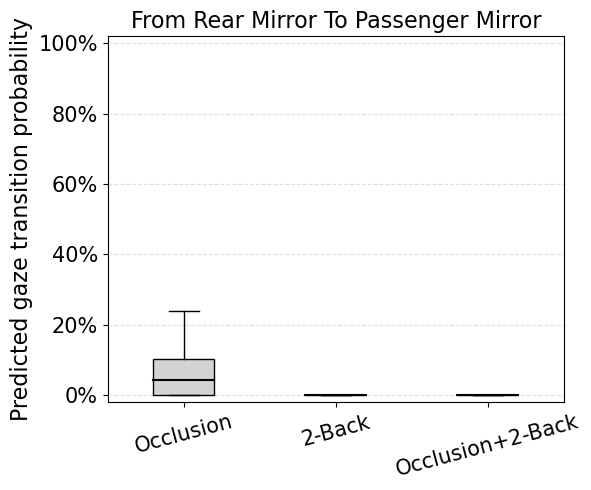


Chain for from_Rear_Mirror_to_Other could not be modelled as variance = 0


DV: from_Rear_Mirror_to_Other
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Other_to_Console could not be modelled as variance = 0


DV: from_Other_to_Console
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Other_to_Driver_Lap could not be modelled as variance = 0


DV: from_Other_to_Driver_Lap
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Other_to_Driver_Mirror could not be modelled as variance = 0


DV: from_Other_to_Driver_Mirror
                  coef  st

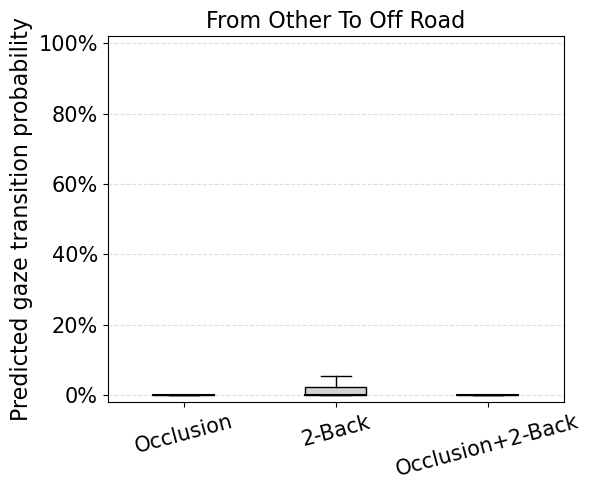


DV: from_Other_to_On_Road
                      coef   std_err         z   p_value
Intercept        -0.039125  0.034417 -1.136804  0.255620
Occlusion_Chains  0.039125  0.034417  1.136804  0.255620
TwoBack_Chains    0.057143  0.030205  1.891811  0.058516

=== Estimated Marginal Means (with Tweedie Variance) ===
  Condition  Predicted_Mean  Predicted_Var
1    (0, 1)    1.387779e-17   7.755234e-18
2    (1, 0)    1.801802e-02   1.006889e-02
3    (1, 1)    5.714286e-02   3.193277e-02

=== Wilcoxon Signed-Rank Comparisons ===
  Condition1 Condition2  Mean_Diff  Wilcoxon_stat       p_value
0     (0, 1)     (1, 0)  -0.046747          253.0  8.200929e-13
1     (0, 1)     (1, 1)  -0.124326          190.0  2.950437e-13
2     (1, 0)     (1, 1)  -0.077579         1127.0  3.062504e-05


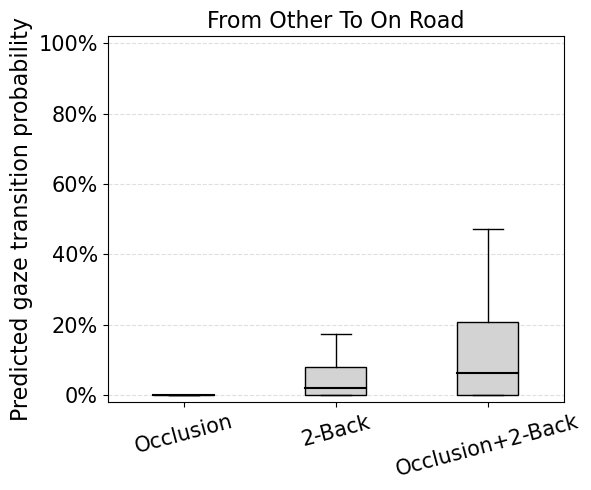


Chain for from_Other_to_Passenger_Mirror could not be modelled as variance = 0


DV: from_Other_to_Passenger_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0

Chain for from_Other_to_Rear_Mirror could not be modelled as variance = 0


DV: from_Other_to_Rear_Mirror
                  coef  std_err    z  p_value
Intercept          0.0      0.0  0.0      1.0
Occlusion_Chains   0.0      0.0  0.0      1.0
TwoBack_Chains     0.0      0.0  0.0      1.0


In [7]:
#defines the col in the dataset where the first gaze transition chain appears in df
firstChain = 3 
# Loop over columns and print significant results
for i in range(firstChain, len (df.columns)):
    DV = df.columns[i]
    
    model, results, emms = run_tweedie_with_emm_and_significance(df, DV)
    if results is not None:
        # Only print if no predictor is significant
        if (results.loc[['Occlusion_Chains', 'TwoBack_Chains'], 'p_value'] <= 0.05).any()==False:
            print(f"\nDV: {DV}")
            print(results)
            
            predictors = ["TwoBack_Chains", "Occlusion_Chains"]
            
            if model is not None:
                    #estimate EMMs, and plot the wilcoxon test results
                    emms_df, pairwise_df = posthoc_and_plot_tweedie_wilcoxon(model, df, DV, predictors, n_sim=105)
